### import packages 

In [1]:
import requests
import geopandas as gpd

import pandas as pd

import zipfile
from io import BytesIO

### download data accident data

In [ ]:
years=['2017','2018','2019','2020','2021','2022','2023']

for year in years:
    response = requests.get("https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte"+year+"_EPSG25832_CSV.zip")
    zipped= zipfile.ZipFile(BytesIO(response.content))
    zipped.extractall("../accident_data")


### parse data to dataframe

In [ ]:

data=pd.DataFrame()
for year in years:
    if year=='2020':
        data_j=pd.read_csv('../accident_data/csv/Unfallorte'+year+'_LinRef.csv', sep=';', low_memory=False)
    if year in ['2021']:
        data_j=pd.read_csv('../accident_data/Unfallorte2021_EPSG25832_CSV/Unfallorte_'+year+'_LinRef.txt', sep=';', low_memory=False)
    if year in ['2022']:
        data_j=pd.read_csv('../accident_data/Unfallorte'+year+'_LinRef.csv', sep=';', low_memory=False)
    if year in ['2017','2018','2019']:
        data_j=pd.read_csv('../accident_data/csv/Unfallorte'+year+'_LinRef.txt', sep=';', low_memory=False)
    if year in ['2023']:
        data_j=pd.read_csv('../accident_data/csv/Unfallorte'+year+'_LinRef.csv', sep=';', low_memory=False)    
    
    #clean df due to diffrent spesifications over the years
    data_j=data_j.rename(columns={"UIDENTSTLAE": "UIDENTSTLA"})
    data_j=data_j.rename(columns={"ULICHTVERH": "LICHT"})
    data_j=data_j.rename(columns={"OBJECTID_1": "OBJECTID"})
        
    data_j=data_j.rename(columns={"IstStrassenzustand": "USTRZUSTAND"})
    data_j=data_j.rename(columns={"STRZUSTAND": "USTRZUSTAND"})

    data_j=data_j.rename(columns={"IstSonstige": "IstSonstig"})
    
    

    # append year data to entire dataframe
    data=pd.concat([data, data_j], ignore_index=True)
data.head()

,OBJECTID,UIDENTSTLA,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,...,IstSonstig,LICHT,USTRZUSTAND,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84,IstGkfz,OID_,PLST
0,1.0,01170113152013852017,1,0,55,12,2017,1,5,6,...,0,2,2,"605079,422900000010000","6001757,554700000200000","10,609031240000036","54,153150062000066",NaN,NaN,NaN
1,2.0,01170113171013912017,1,0,60,53,2017,1,6,6,...,1,2,1,"582297,218400000010000","5969288,968000000300000","10,251497589000053","53,865551422000067",NaN,NaN,NaN
2,3.0,01170106105132242017,1,0,61,11,2017,1,18,6,...,0,2,1,"522799,299999999990000","5990575,725999999800000","9,348343807000049","54,062896651000074",NaN,NaN,NaN
3,4.0,01170114152013542018,1,0,55,42,2017,1,12,7,...,0,0,0,"616128,937799999960000","5981557,289699999600000","10,770405204000042","53,969301629000029",NaN,NaN,NaN
4,5.0,01170106161013732017,1,0,62,60,2017,1,8,6,...,0,0,1,"581575,998700000000000","5934905,202899999900000","10,231475138000064","53,556683829000065",NaN,NaN,NaN


### prepare coordinats for geocoding

<Axes: >

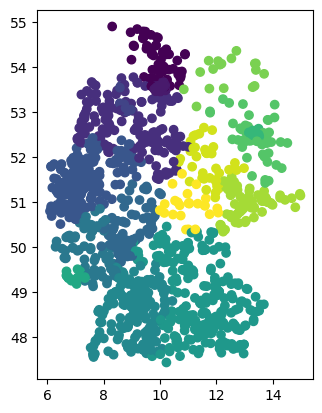

In [4]:
data.YGCSWGS84=data.YGCSWGS84.str.replace(',','.').astype(float)
data.XGCSWGS84=data.XGCSWGS84.str.replace(',','.').astype(float)

# create geocoded geodataframe fom dataframe
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.XGCSWGS84,data.YGCSWGS84), crs='EPSG:4326')

#testplot jeder 1000te 
gdf[::1000].plot(column='ULAND')

# testplot Berlin-Brandenburg
#gdf[gdf.ULAND.isin([11,12])][::100].plot()

In [5]:
# drop some columns to keep exporter happy
gdf=gdf.drop(columns=['LINREFX', 'LINREFY','XGCSWGS84','YGCSWGS84','UIDENTSTLA'])

### export to geopackage / geojson 

In [ ]:
# add spatial index to read it faster with a mask later in the process
gdf.to_file("../accident_data/accidents_germany_2017-2023_si.gpkg", SPATIAL_INDEX=True)
gdf.to_parquet("../accident_data/accidents_germany_2017-2023_si.parquet")